<a href="https://colab.research.google.com/github/HwangYHa/Artificial-Intelligence/blob/main/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐렴이란?

**폐렴은 주로 폐포라고 알려진 작은 공기주머니에 영향을 미치는 폐의 염증성 질환입니다.증상에는 일반적으로 마른 기침, 가슴 통증, 발열 및 호흡곤란 등이 있습니다. 증상의 심각도는 다양합니다. 폐렴은 보통 바이러스나 박테리아에 감염되어 발생하며, 다른 미생물, 특정 약물, 자가면역질환 등으로 발병하는 경우는 적습니다. 위험인자로는 낭포성 섬유증, 만성폐쇄성폐질환(COPD), 천식, 당뇨병, 심부전, 흡연 이력, 뇌졸중 발생, 면역력 약화 등이 있습니다. 폐렴 진단은 증상 발생과 신체검사를 기반으로 이루어 집니다. 흉부 엑스레이, 혈액 검사, 가래 배양 등이 진단을 확인하는 데 도움이 될 수 있습니다. 이 질병은 지역사회, 병원, 의료 관련 등 발병 장소에 따라 분류할 수 있습니다.**


In [ ]:
# Python 3 환경에는 많은 유용한 분석 라이브러리가 있습니다.
# image는 kaggle/python docker에 정의되어 있습니다: https://github.com/kaggle/docker-python
# 예를 들어 다음은 로드할 수 있는 몇 가지 유용한 패키지입니다.

import numpy as np    # 선형 대수 지원 라이브러리
import pandas as pd   # 데이터 처리, CSV 파일 I/O(예: pd.read_csv)
import os

# 필요한 라이브러리 가져오기

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# 폐렴 데이터 세트에 대한 설명

**데이터 세트는 3개의 폴더(train, test, val)로 구성되며 각 이미지 범주(Pneumonia/Normal)에 대한 하위 폴더를 포함합니다. 5,863개의 X-Ray 이미지(JPEG)와 2개의 카테고리(Pneumonia/Normal)가 있습니다. 흉부 X선 영상(전후방)은 소아 환자 소급 집단에서 선택되었습니다. 모든 흉부 X선 영상 촬영은 환자의 일상적인 임상 치료의 일부로 수행되었습니다. 흉부 X선 영상의 분석을 위해, 흉부 X선 사진은 품질 관리를 위해 품질이 낮거나 읽을 수 없는 이미지는 모두 제거하고 선별하였습니다. AI 시스템을 훈련시키기 전에 두 명의 전무 의사가 이미지에 대한 라벨 분류 작업을 진행하였습니다. 오류를 방지하기 위해 세 번째 전문가가 평가 세트도 확인했습니다.**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # 원하는 크기로 이미지 크기 변경
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# 데이터세트 불러오기

In [ ]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

<ipython-input-7-6f953d424b35>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# 데이터 시각화 및 전처리

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

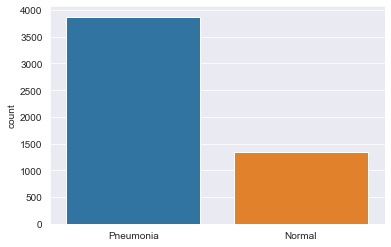

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
        
sns.set_style('darkgrid')
sns.countplot(l)        

**데이터의 균형이 맞지 않습니다. 학습 사례를 늘리기 위해 데이터 확대 기법을 사용할 것입니다.**

**두 클래스의 이미지 미리보기**

Text(0.5, 1.0, 'NORMAL')

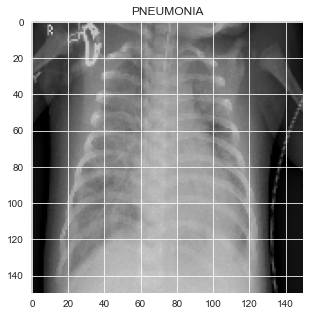

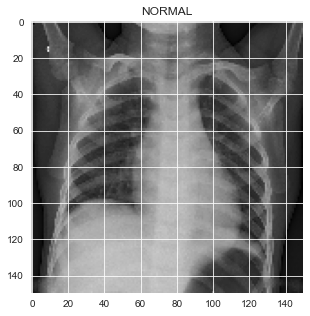

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**조도 차이의 영향을 줄이기 위해 그레이스케일 정규화를 수행합니다. 또한 CNN은 [0..255] 보다 [0..1] 데이터에서 더 빠르게 수렴할 수 있습니다.**

In [ ]:
# 데이터 정규화
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# 딥 러닝을 위한 데이터 크기 조정
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# 데이터 확대

**과적합 문제를 방지하려면 데이터 세트를 인위적으로 확장해야 합니다. 기존 데이터 세트를 훨씬 더 크게 만들 수 있습니다. 기본 아이디어는 데이터의 다양성을 위해 작은 변환으로 훈련 데이터를 변경하는 것입니다. 레이블을 동일하게 유지하면서 배열 표현을 변경하는 방식으로 훈련 데이터를 변경하는 방식을 데이터 확대 기법이라고 합니다.많이 사용되는 확대 기법으로 그레이스케일(grayscales), 수평 플립(horizontal flips), 수직 플립(vertical flips), 무작위 자르기(random crops), 컬러 지터(color jitters), 번역(translations), 회전(rotations) 등이 있습니다. 이러한 변환 기법 중 몇 가지만 훈련 데이터에 적용하면 훈련 사례 수를 두 배 또는 세 배로 쉽게 늘리고 매우 강력한 모델을 만들 수 있습니다.**

In [ ]:
# 과적합을 방지하고 데이터 세트의 불균형을 처리하기 위한 데이터 확대

datagen = ImageDataGenerator(
        featurewise_center=False,              # 데이터셋에 대해 입력 평균을 0으로 설정
        samplewise_center=False,               # 각 샘플 평균을 0으로 설정
        featurewise_std_normalization=False,   # 데이터 세트의 표준으로 입력 나눕니다.
        samplewise_std_normalization=False,    # 각 입력을 std로 나눕니다.
        width_shift_range=0.1,                 # 이미지를 가로로 무작위로 이동(전체 너비의 일부)
        height_shift_range=0.1) 


datagen.fit(x_train)

데이터 확대를 위해 다음을 선택했습니다.
1. 일부 훈련 이미지를 무작위로 30도 회전
2. 일부 훈련 이미지를 무작위로 20% 확대
3. 너비의 10%만큼 이미지를 가로로 무작위로 이동
4. 높이의 10%만큼 이미지를 세로로 무작위로 이동
5. 이미지를 가로로 무작위로 뒤집음

모델이 준비되면 훈련 데이터 세트에 맞춥니다.

# 모델 훈련

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_60 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_48 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_61 (Bat  (None, 75, 75, 64)     

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 160s 968ms/step - loss: 0.5099 - accuracy: 0.8585 - val_loss: 29.0738 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 157s 964ms/step - loss: 0.2211 - accuracy: 0.9283 - val_loss: 51.4615 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9425
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 157s 966ms/step - loss: 0.1772 - accuracy: 0.9425 - val_loss: 51.6240 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 156s 955ms/step - loss: 0.0985 - accuracy: 0.9657 - val_loss: 1.9402 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 160s 983ms/step - loss: 0.0811 - accuracy: 0.9701 - val_loss: 3.0179 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/12
163/163 [=========

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 6s 281ms/step - loss: 1.2941 - accuracy: 0.8141
Loss of the model is -  1.2941124439239502
20/20 [==============================] - 6s 274ms/step - loss: 1.2941 - accuracy: 0.8141
Accuracy of the model is -  81.41025900840759 %


# 모델 훈련 후 분석

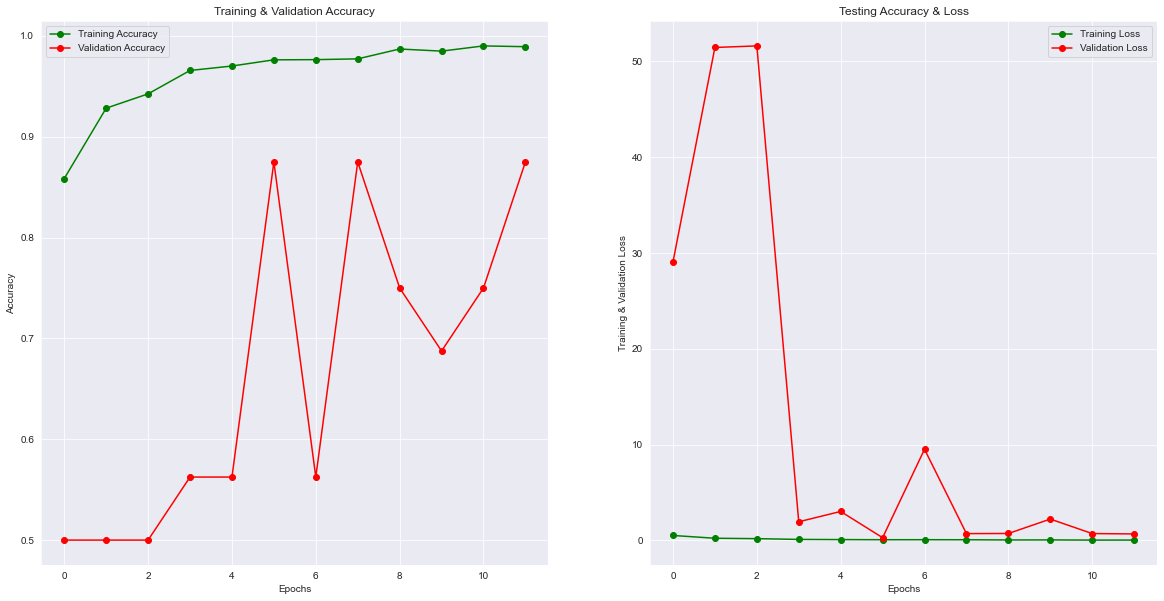

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predicted = (model.predict(x_test) > 0.5).astype("int32")
predictions = predicted.reshape(1,-1)[0]

predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.77      0.99      0.87       390
   Normal (Class 1)       0.98      0.51      0.67       234

           accuracy                           0.81       624
          macro avg       0.88      0.75      0.77       624
       weighted avg       0.85      0.81      0.80       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[388,   2],
       [114, 120]], dtype=int64)

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

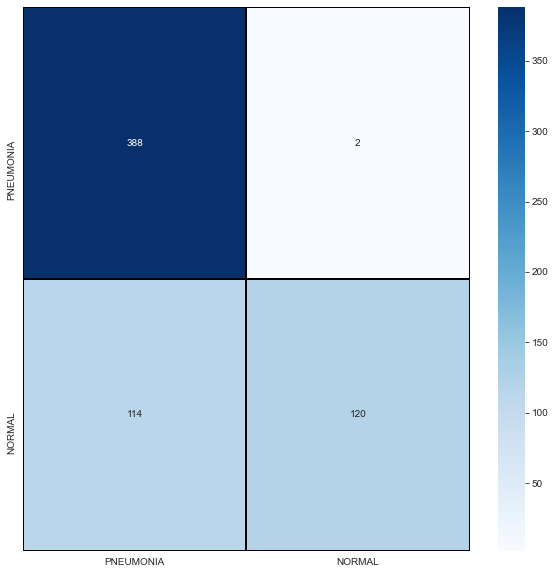

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**올바르게 예측된 클래스 샘플**

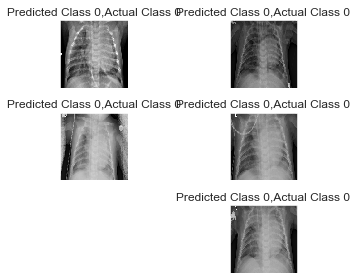

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**올바르지 않게 예측된 클래스 샘플**

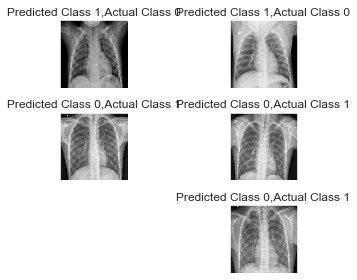

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1